## Python-gmt Test with FSU/NOAA Ship Data from ERDDAP


__pyversion__==3.6   
__author__==S.Bell

In [4]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np
import datetime

server_url='https://coastwatch.pfeg.noaa.gov/erddap'
e = ERDDAP(server=server_url)

Get only WTEP(Dyson) Ship NRT datafiles   
-NRT files exist back to the start of the year   
-qc files exist back to 2007?

In [20]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='wtepnrt'))

In [21]:
boats = df['Dataset ID'].values
print(boats)

['fsuNoaaShipWTEPnrt']


In [22]:
kw = {
    'min_lon': 0,
    'max_lon': 540,
    'min_lat': 50.0,
    'max_lat': 90.0,
    'min_time': '2015-01-10T00:00:00Z',
    'max_time': str(datetime.datetime.now()),
    'cdm_data_type': 'trajectory'
}

In [23]:
variables = [e.get_var_by_attr(dataset_id=ship, 
                               long_name=lambda v: v is not None) for ship in boats]


In [45]:
common_variables = set(variables[0]).intersection(*variables[1:])

common_variables.remove('flag') 
common_variables

{'airPressure',
 'airTemperature',
 'conductivity',
 'latitude',
 'longitude',
 'platformCourse',
 'platformHeading',
 'platformSpeed',
 'platformWindDirection',
 'platformWindSpeed',
 'relativeHumidity',
 'salinity',
 'seaTemperature',
 'time',
 'windDirection',
 'windSpeed'}

In [46]:
constraints = {
    'longitude>=': kw['min_lon'],
    'longitude<=': kw['max_lon'],
    'latitude>=': kw['min_lat'],
    'latitude<=': kw['max_lat'],
    'time>=': kw['min_time'],
    'time<=': kw['max_time'],
}

download_url = e.get_download_url(
    dataset_id=boats[0],
    protocol='tabledap',
    response='csv',
    variables=common_variables,
    constraints=constraints
)

print(download_url)

https://coastwatch.pfeg.noaa.gov/erddap/tabledap/fsuNoaaShipWTEPnrt.csv?windDirection,platformWindDirection,airTemperature,platformWindSpeed,platformSpeed,windSpeed,platformCourse,latitude,platformHeading,conductivity,seaTemperature,relativeHumidity,longitude,airPressure,salinity,time&longitude>=0&longitude<=540&latitude>=50.0&latitude<=90.0&time>=1420848000.0&time<=1526542852.340159


In [47]:
from requests.exceptions import HTTPError

dfs = {}
for ship in boats:
    print(ship)
    try:
        e = ERDDAP(server=server_url,
            dataset_id=ship,
            protocol='tabledap',
            response='csv',
            variables=common_variables,
            constraints=constraints
        )

        dfs.update({ship: e.to_pandas(
                            index_col='time',
                            parse_dates=True,
                            skiprows=(1,)  # units information can be dropped.
                            )})
    except HTTPError:
        print('Failed to generate url {}'.format(float))
        continue


fsuNoaaShipWTEPnrt


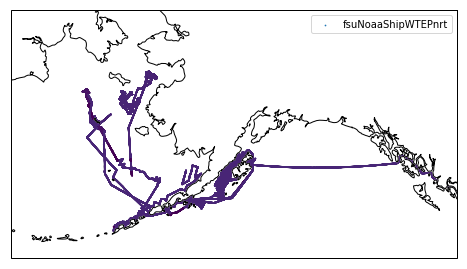

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(8, 8),
                           subplot_kw=dict(projection=projection))
    if projection == ccrs.PlateCarree():
        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

projection=ccrs.LambertConformal(central_longitude=-160.0)
transformation=ccrs.PlateCarree()

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='1.0')

dx = dy = 0.5
extent = -180, -130, kw['min_lat']+dy, kw['max_lat']+dy
extent = [-180, -130, 50, 66]
fig,ax = make_map(projection=projection)
for ship, df in dfs.items():
    ax.scatter(df['longitude'], df['latitude'], c=df['salinity'], s=0.5, label=ship, transform=transformation)

leg = ax.legend()

ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)

### Testing gmt-python as alternative plotting platform over cartopy or basemap

In [49]:
import gmt

In [50]:
fig = gmt.Figure()

fig.coast(region=[-180, -140, 50, 80], projection='B-160/60/55/60/6i', land='lightgray', water='gray',
          frame=True,U=True)

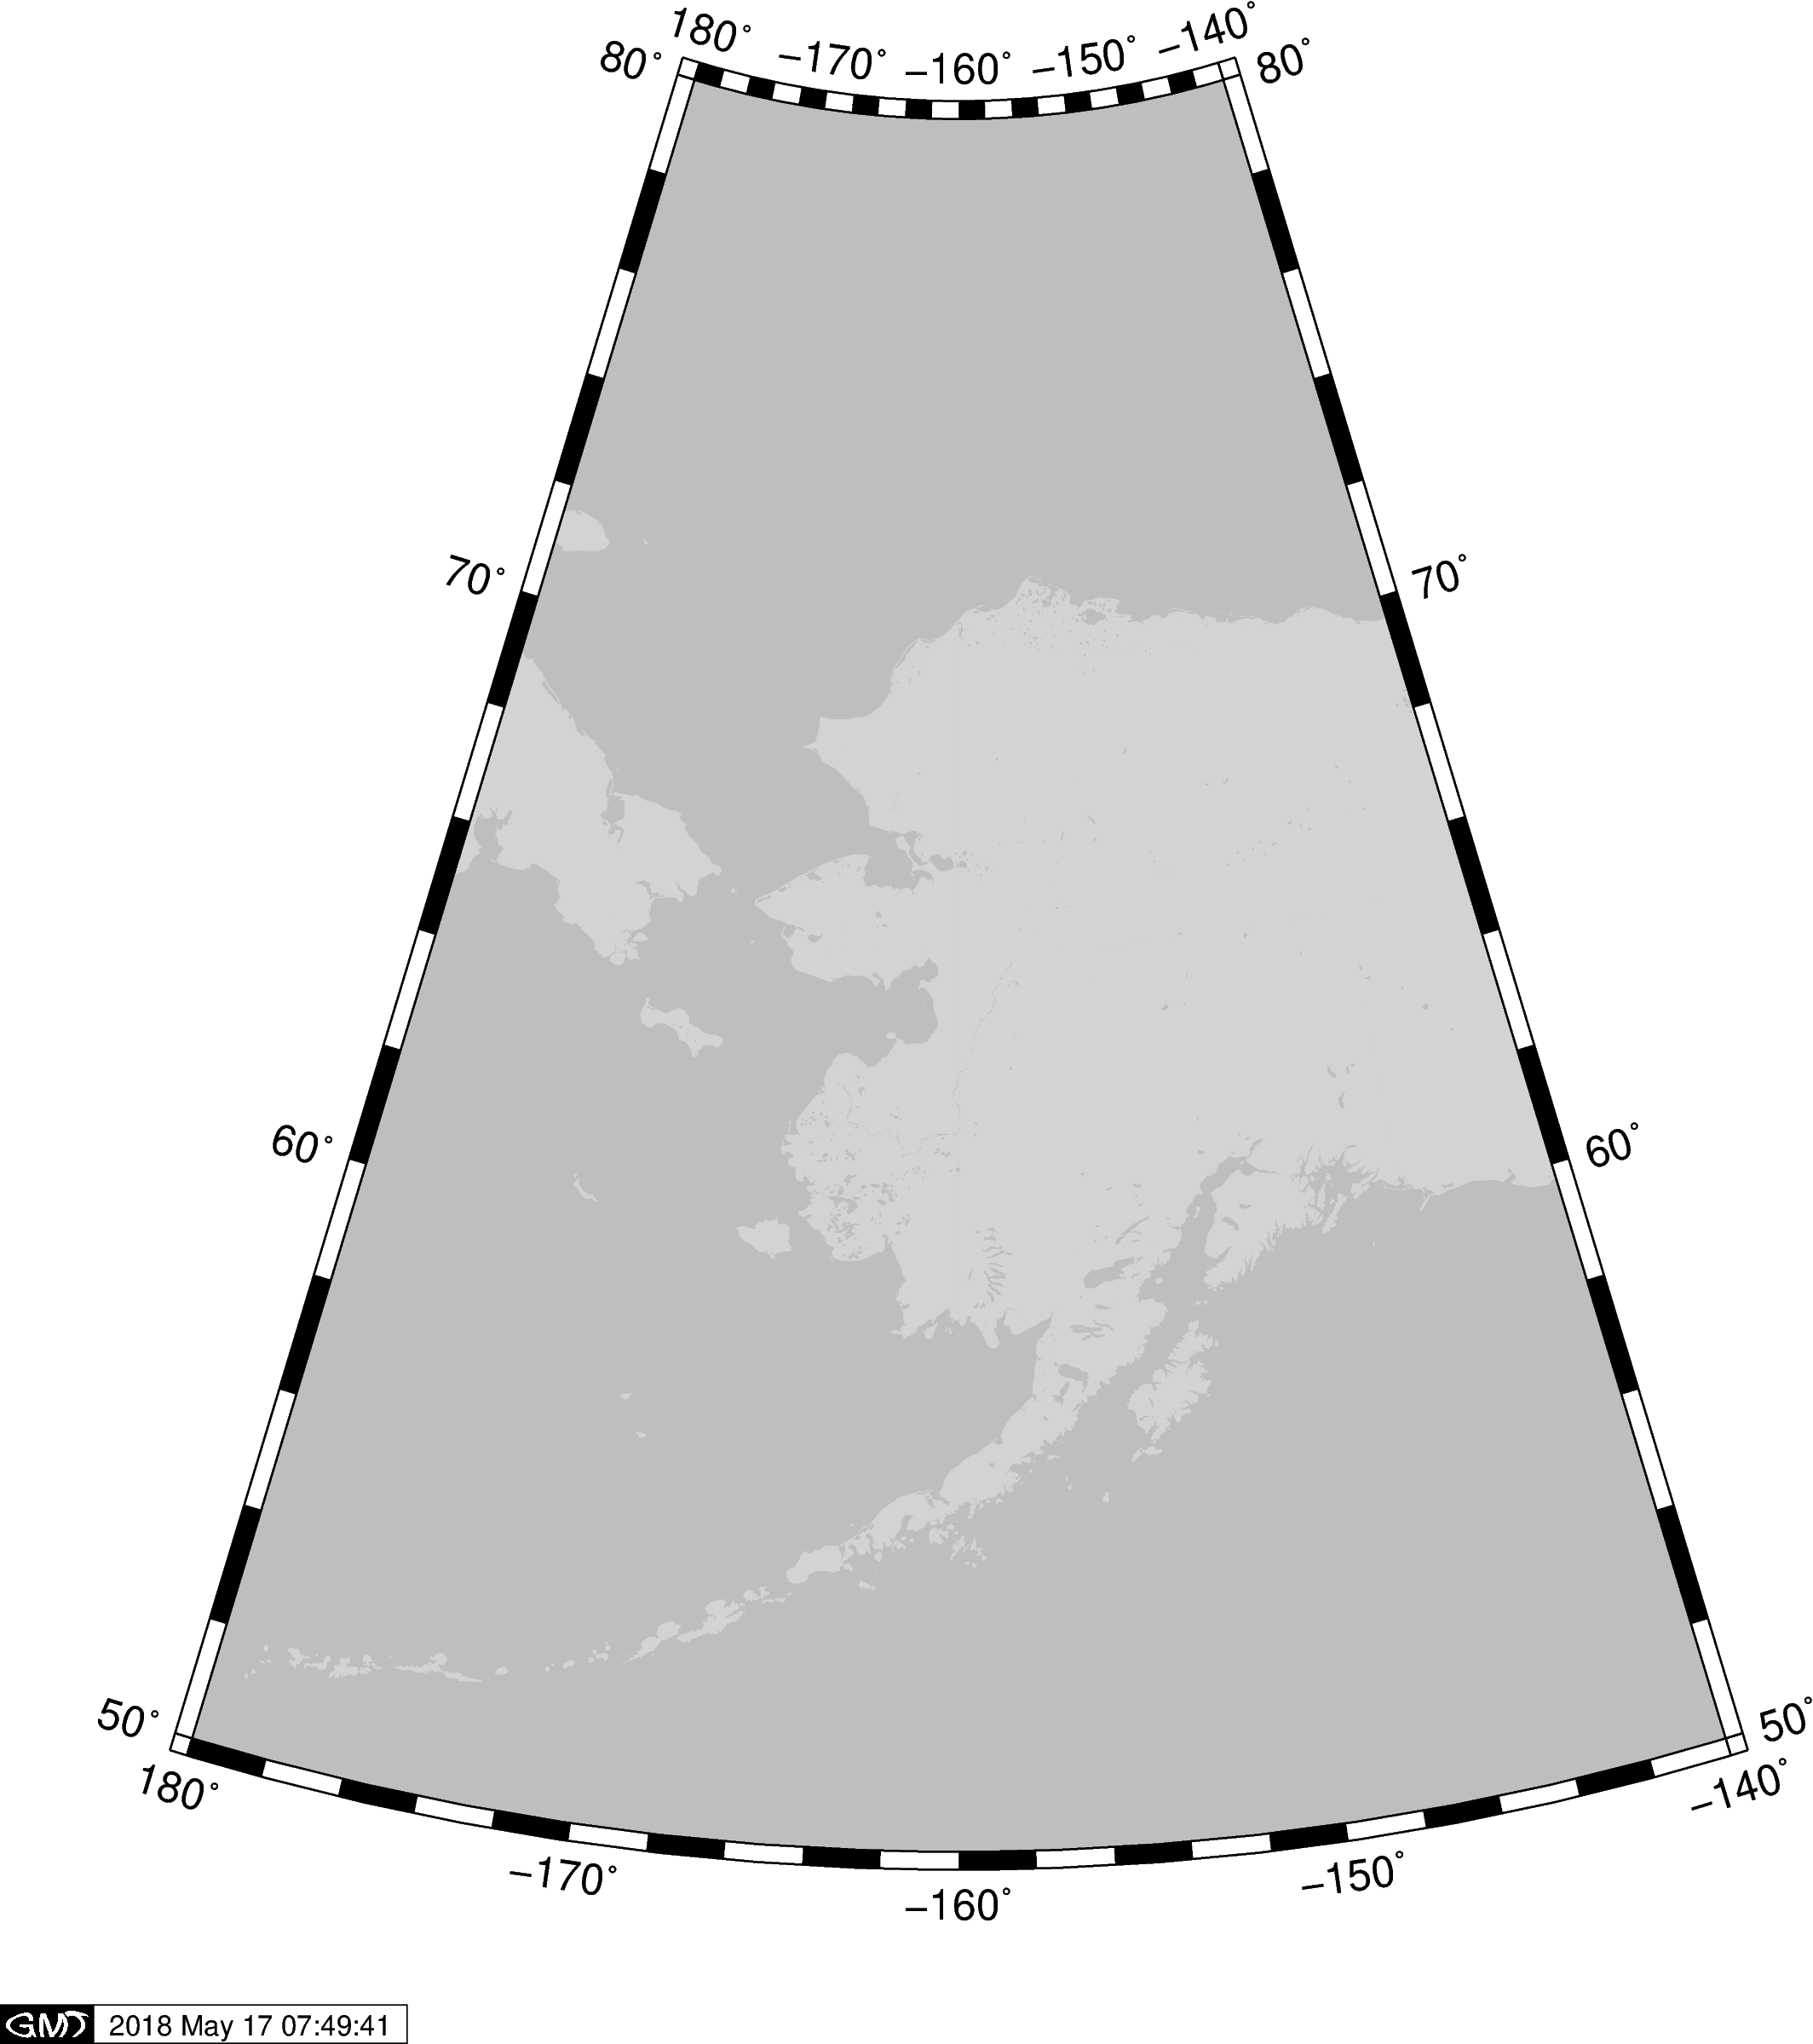

In [51]:
fig.show()

In [52]:
#color by year
clist=['red']
count=0
for ship, df in dfs.items():
    fig.plot(x=df.longitude, y=df.latitude, color=clist[count], style='p0.05')
    print(clist[count])
    count+=1

red


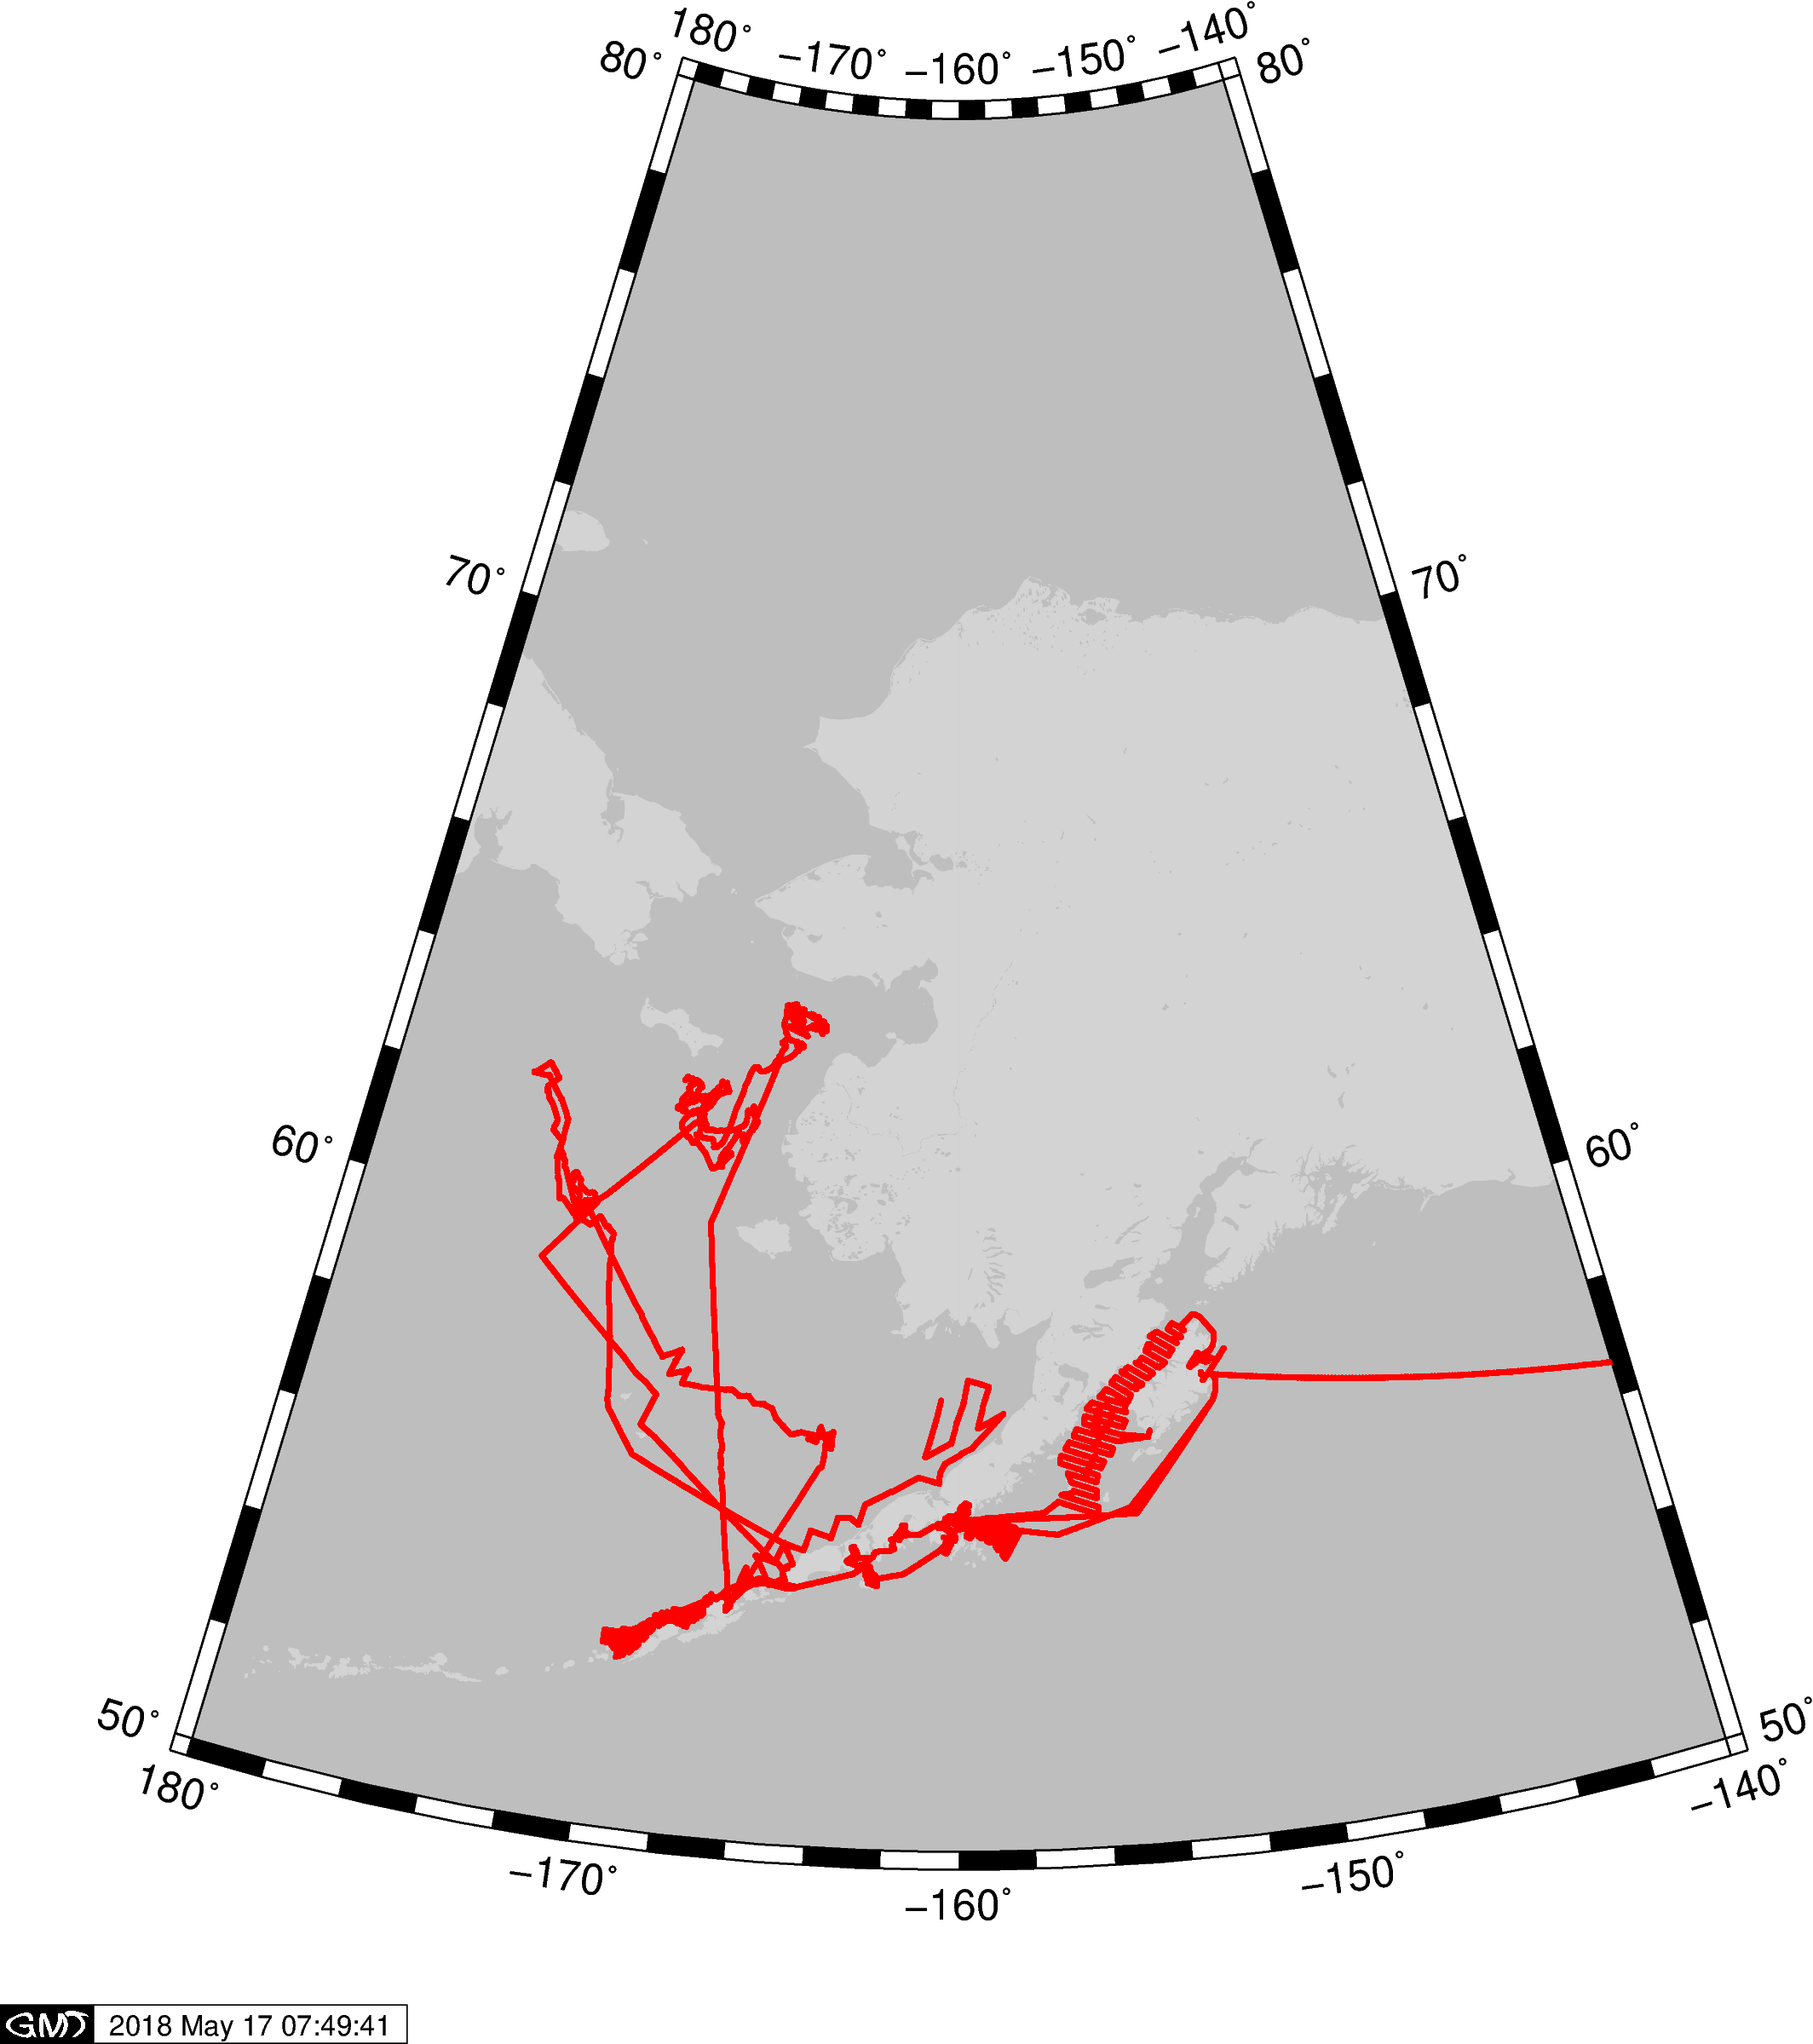

In [53]:
fig.show()

In [54]:
fig1 = gmt.Figure()

fig1.coast(region=[-180, -140, 50, 80], projection='B-160/60/55/60/6i', land='lightgray', water='gray',
          frame=True,U=True)

Using the cmocean colormaps for gmt found at http://soliton.vm.bytemark.co.uk/pub/cpt-city/cmocean/ (these must be installed in the {conda}/{gmt_env}/share/gmt/cpt/ path where conda is the path to your conda installation and gmt_env is the environment gmt is running in)

In [55]:
#color by sst
for ship, df in dfs.items():
    #choose temp boundaries
    dfmiss = df.copy()
    dfmiss.seaTemperature.loc[(df.seaTemperature > 15) | (df.seaTemperature <-2)] = np.nan
    # normalize data for colormap
    dfnorm = dfmiss.apply(lambda x: (x - (-2)) / (15 - (-2)))
    fig1.plot(x=dfmiss.longitude, y=dfmiss.latitude, color=256*dfnorm.seaTemperature, cmap='thermal', style='c0.05c')


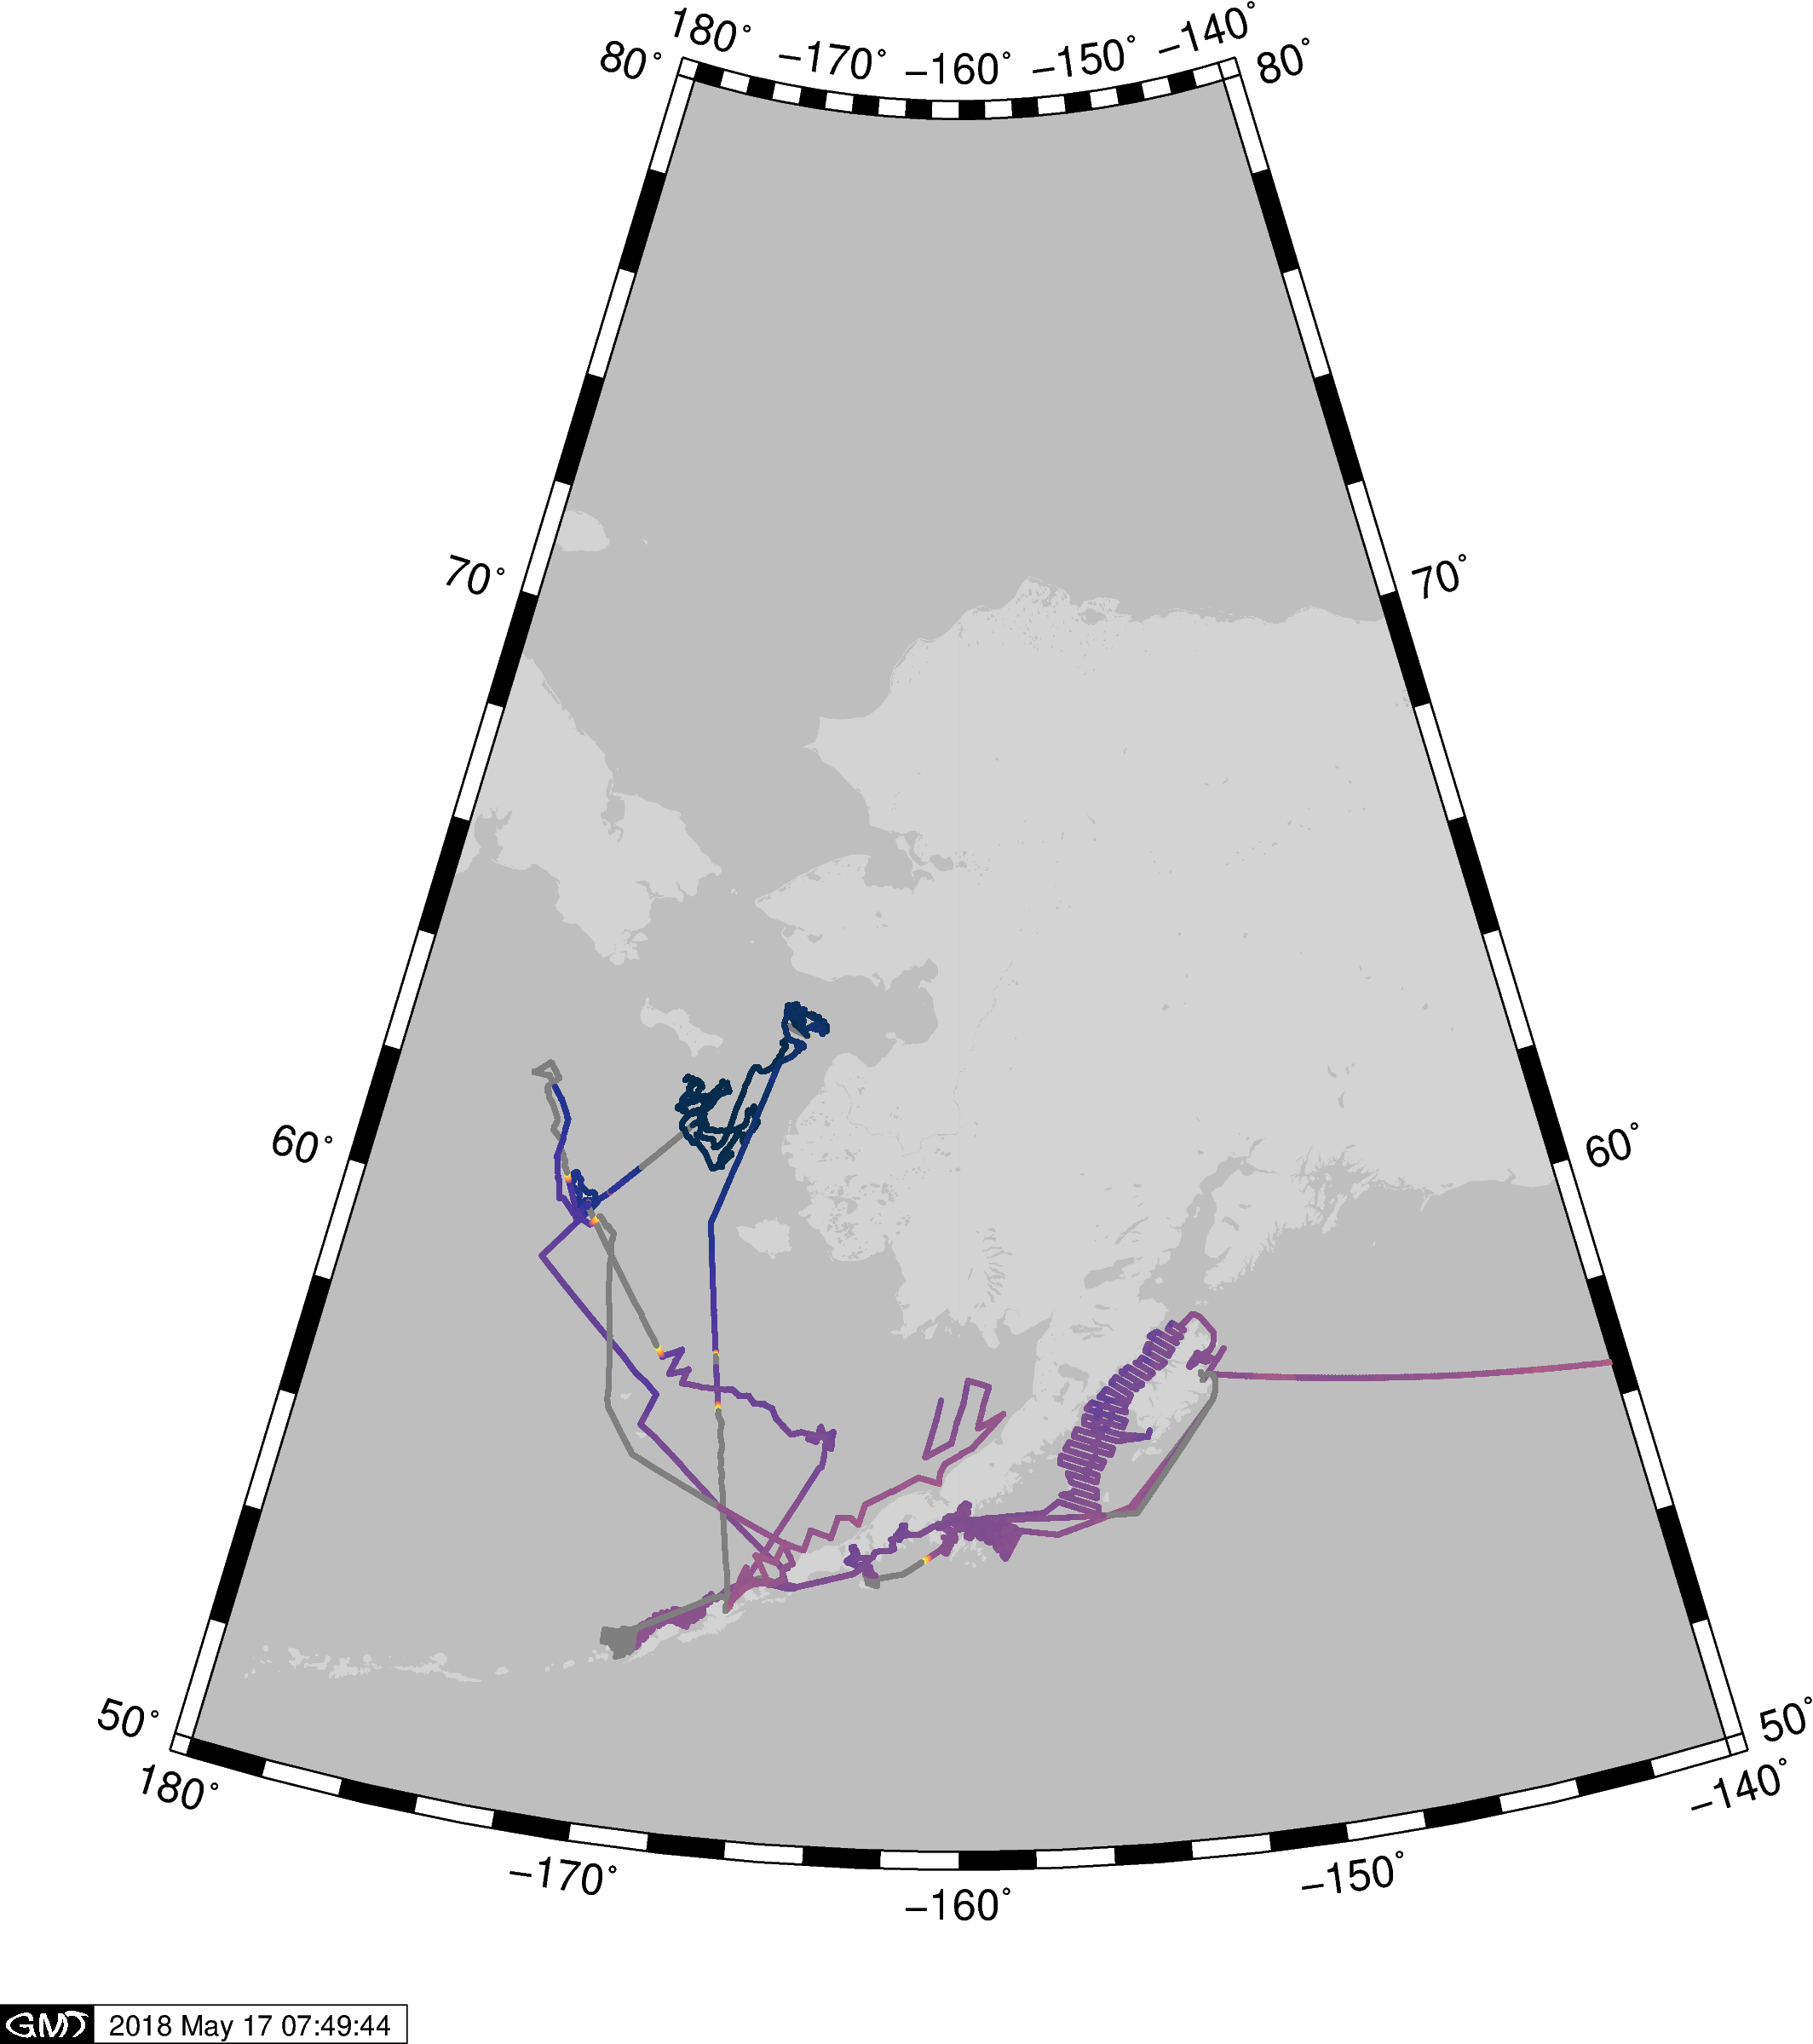

In [56]:
fig1.show()

In [31]:
dfmiss

,sst,trajectory_id,voltage,strain,longitude,latitude
time,,,,,,
2018-01-01 00:25:00,-2.00,122542,14.2,0.0,517.896,74.259
2018-01-01 00:37:00,-2.00,122542,14.2,0.0,517.892,74.259
2018-01-01 01:25:00,-2.00,122542,14.2,1.0,517.887,74.262
2018-01-01 01:50:00,-2.00,122542,14.2,1.0,517.892,74.264
2018-01-01 02:06:00,-2.00,122542,14.2,0.0,517.893,74.264
2018-01-01 02:17:00,-2.00,122542,14.2,0.0,517.895,74.264
2018-01-01 03:33:00,-2.00,122542,14.2,1.0,517.897,74.269
2018-01-01 03:47:00,-2.00,122542,14.2,1.0,517.899,74.269
2018-01-01 03:57:00,-2.00,122542,14.2,1.0,517.902,74.269
